[Return to Portfolio Page](https://sebastianghafafian.github.io/Portfolio/)


# Model Evaluation

Check out the project on [Github](https://github.com/SebastianGhafafian/CNN_Circle).

**Keywords**:
Convolutional Neural Networks (CNN), Pytorch, Regression, Data visualization, Pandas

## Introduction and motivation

In my master's thesis I wrote code to automatically detect ellipses in gray-scale images as a minor side project. Back then I had little knowledge of machine learning and I always wanted to revisit the topic later. After recently finishing my MicroMaster in Statistics and Data Science I thought I could try to solve a similar task using a neural network. I build a smaller working sample with a single circle in a image and fully connected feed forward networks. I tried to detect the (x,y) position of the circle center inside the image. That worked well. Then I introduced noise to see how far I could push the model and after that tried to detect the radius as well. In the end, I kind of drifted away from my inital motivation and became more curious how far I could push the model and whether a convolutional neural network could be a better solution for the task. The idea seemed interesting to me as I haven't seen to many applications of convolutional network for a regression task.

In the end, I ended up comparing two CNN models to predict the circle center and radius  and their performance for different noise levels. In this analysis, I explain the models I ended up using with a focus on the model's behavior on the test set.

## Dataset

40000 images have been created using the create_dataset.py. These binary images are 100 x 100 pixels containing a white circle with a random shape (radius r) and position (x,y). 
First the radius is randomly drawn from a discrete uniform distribution between 5 and 14 pixels. Then, the circle center position is randomly drawn from a discrete uniform distribution in x and y in the borders of [r,100-r] to avoid incomplete circles in the images. During training and testing, the data loader applies a transformation to the images adding Gaussian noise with zero mean and a varying standard deviation (from here on called noise level). The models are trained on different noise levels in range of [0.1, 0.3, 0.5, 0.7, 0.9, 1.1].
The image showcases the levels of noise for one image.

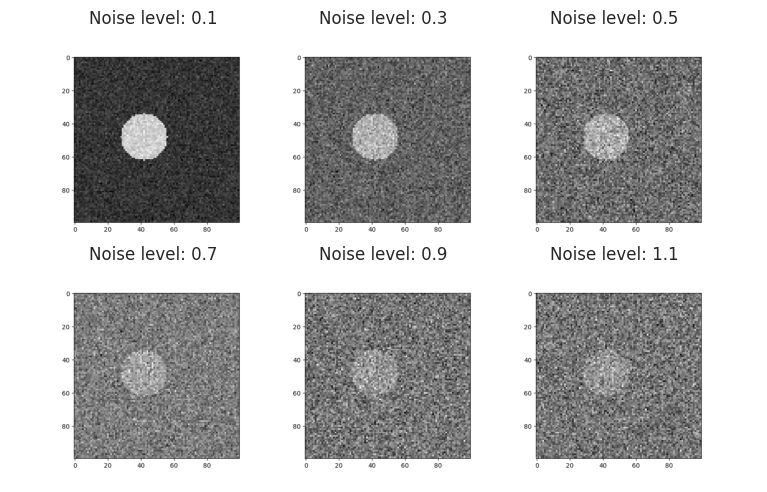

In [23]:
#import libraries 
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

# create figure to showcas different level of noises
f, axs = plt.subplots(2, 3, figsize=(15, 5))
plt.tight_layout()

noise_levels = np.array([[0.1, 0.3, 0.5],
                        [0.7, 0.9, 1.1]])
# Read image
for i in range(2):
    # Adds a subplot at the 1st position 
    for j in range(3):
        noise = noise_levels[i,j]
        img = cv2.imread(f'./img/img319_{noise}.png') 
        # showing image 
        axs[i,j].imshow(img) 
        axs[i,j].axis('off')
        plt.axis('off') 
        axs[i,j].set_title(f"Noise level: {noise}") 

plt.subplots_adjust(left=0.1, right=0.6, bottom=0.05, top=0.95, wspace=-0.2, hspace=0.1)



### Flaw in dataset

The randomly drawn radius of the circle determines the possible position of the circle center.
For example: If the drawn radius is 14, then a circle center is only possible in between [14,86] for x and y.
If the drawn radius is 5, then a circle center is possible in between [5,95] for x and y.
This will result in a smaller representation of circles with x or y positions near the edges between 5-15 and between 85-95. This flaw is later seen in the histograms. 
This should not be the biggest problem for convolutional neural networks
(maybe plot a 3d histogram or heat map of the x,y, positions)


## Model architecture and loss function

The loss function for this regression task has been set to the mean squared error. There are two models of varying complexity compared. The first convlolution network named **CustomCNN3** contains two convolutional layers for feature mapping and 3 fully connected layers for the regression task with a total amount of parameters of 23147.

<img src="./img/CustomCNN3.png" alt="CustomCNN3" width="800"/>


The second model called **CustonCNN5** contains 5 convolutional layers and three fully connected layers with a total amount of parameters of 270527.


<img src="./img/CustomCNN5.png" alt="CustomCNN5" width="800"/>

## Model training

The models are trained using 80 % of the data set for training. For each model for a specific level of noise, a gaussian filter is used to introduce noise to the picture. Each model is trained on the same split of training and test data totalling 12 different models. For most models it was sufficient to train for 15 epochs regarding the training time. Analysis during training has shown that the fluctuations in later learning stage come from the prediction of the radius, rather than the position. The following plot shows the test loss that occured during training. These plots are further discussed in the Lessons Learnt section of this report.

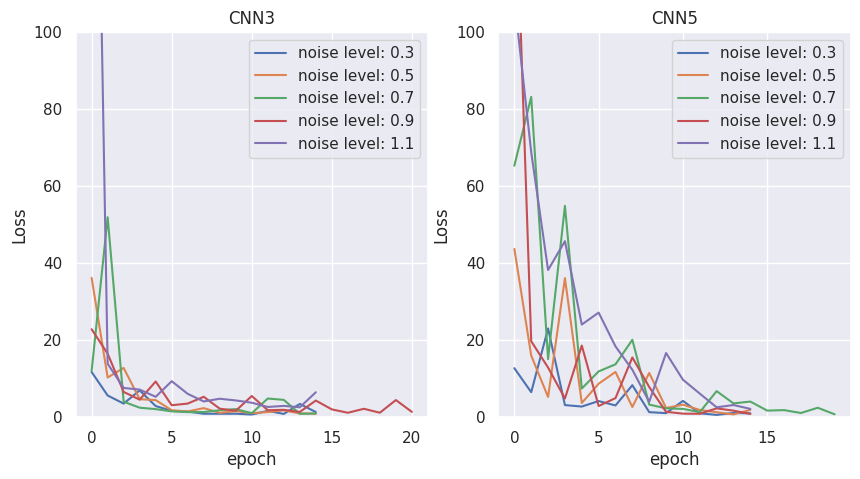

In [24]:
# import loss over epochs
noise_levels = [0.3,0.5,0.7,0.9,1.1]
loss_list = []
for noise_lvl in noise_levels:
    noise = pd.read_csv(f'./models/loss/CustomCNN3_noise_{noise_lvl}.csv')
    noise['noise']=noise_lvl
    loss_list.append(noise)
loss_history_CNN3 = pd.concat(loss_list)

loss_list = []
for noise_lvl in noise_levels:
    noise = pd.read_csv(f'./models/loss/CustomCNN5_noise_{noise_lvl}.csv')
    noise['noise']=noise_lvl
    loss_list.append(noise)
loss_history_CNN5 = pd.concat(loss_list)

f, axs = plt.subplots(1, 2, figsize=(10, 5))
for noise_lvl in noise_levels:

    plot_data_CNN3 = loss_history_CNN3[loss_history_CNN3['noise']==noise_lvl]
    plot_data_CNN5 = loss_history_CNN5[loss_history_CNN5['noise']==noise_lvl]
    sns.lineplot(ax= axs[0], data= plot_data_CNN3, x = plot_data_CNN3.index, y='Loss',label=f'noise level: {noise_lvl}')
    sns.lineplot(ax= axs[1], data= plot_data_CNN5, x = plot_data_CNN5.index, y='Loss',label=f'noise level: {noise_lvl}')
axs[0].set_ylim([0,100])
axs[0].set_xlabel('epoch')
axs[0].set_title('CNN3')
axs[1].set_ylim([0,100])
axs[1].set_title('CNN5')
axs[1].set_xlabel('epoch')
plt.show()

## Model Analysis


The model evaluation takes place on multiple levels. On qualitative level, a random sample is drawn and labels and predicted values are compared visually. This allows to gain some intuition of what might be going wrong or not as intended. This was mainly done during training of the model. 



On a quantitative level, the histograms of true labels and and predicted labels are compared to the performance of the model and to identify weaknesses. Further, the root mean squared error for each predicted variable, representing the average error in pixels for the estimation.

Is it more difficult for the model to predict labels for circles being at the edge of the picture?
How many weights had to be trained vs the amount of available data?

### Qualitative Analysis

To get an overview of the model's performance, it is useful to showcase the predicted values on the actual images.

<Figure size 800x800 with 0 Axes>

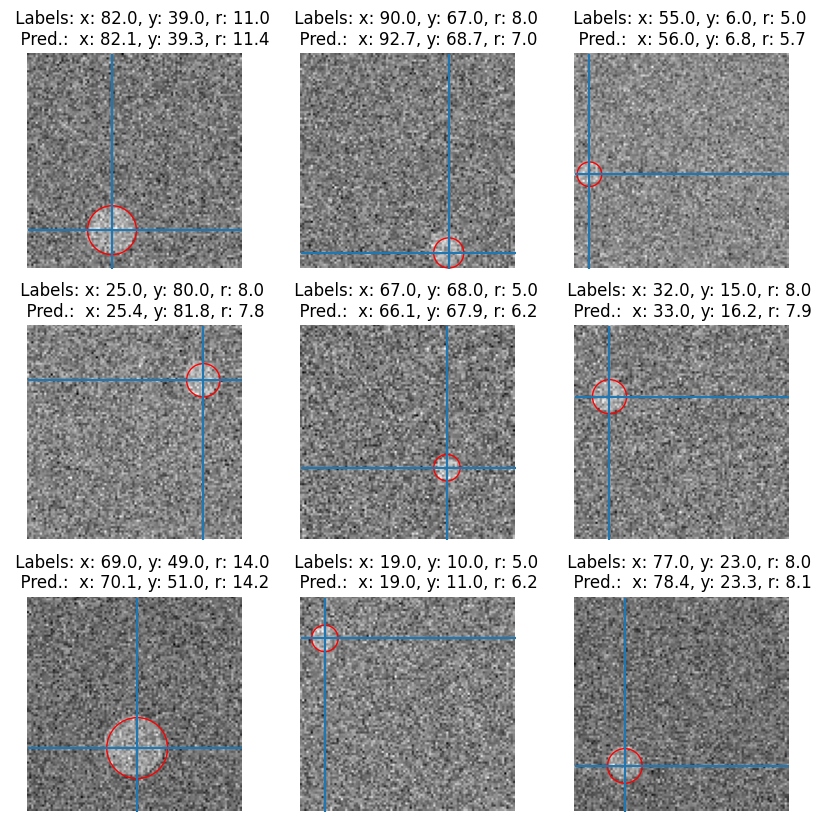

In [4]:
import torch
import networks
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import Circle
import utils
import networks

#choose model to display
model = networks.CustomCNN3()
noise_lvl = 0.7
# load trained model
model.load_state_dict(torch.load(f'./models/CustomCNN3_noise_lvl_{noise_lvl}.pt',map_location=torch.device('cpu')))
model.eval()

## load data set
# define the train and val splits
train_split = 0.80
test_split = 1 - train_split

#add gassian noise to training data
data_set = utils.CustomImageDataset(annotations_file="./data/annotations.csv",img_dir="./data",transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    utils.AddGaussianNoise(mean = 0, std = noise_lvl)]))

# set number of training samples
numTrainingSamples = int(len(data_set) * train_split)
# set number of test samples
numTestSamples = int(len(data_set) - numTrainingSamples)

# draw randomly from data
(trainData, testData) = random_split(data_set,
	[numTrainingSamples, numTestSamples],
	generator=torch.Generator().manual_seed(42))


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# visualize the model performance using the images

# set up a canvas of 3 x 3 subplots
plt.rcParams['figure.figsize'] = [10, 10]
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
fig, axes = plt.subplots( rows, cols )
# plot image and prediction
for i in range(rows):
   for j in range(cols):
      # get random index of test sample
      sample_idx = torch.randint(len(testData), size=(1,)).item()
      # get random test sample
      img, label = testData[sample_idx]
      # whats happening here???
      img.unsqueeze_(1)
      # set image to device
      img = img.to(device)
      # get prediction vector (x,y,r) from model
      pred = model(img).squeeze()
      # what does .item() do ???
      x_pred, y_pred, r_pred = pred[0].item(), pred[1].item(), pred[2].item()

      img = img.to('cpu')
      # figure.add_subplot(rows, cols, i)
      axes[i,j].set_title(f" Labels: x: {label[0]}, y: {label[1]}, r: {label[2]}\n  Pred.:  x: {x_pred:.1f}, y: {y_pred:.1f}, r: {r_pred:.1f}")
      axes[i,j].axis("off")
      axes[i,j].imshow(img.squeeze(), cmap="gray") #what does this do???
      axes[i,j].hlines([x_pred,x_pred],0,100)
      axes[i,j].vlines([y_pred,y_pred],0,100)
      circ = Circle((y_pred,x_pred),r_pred,fill = False, edgecolor = "r")
      axes[i,j].add_patch(circ);

### Quantitative Analysis

### Distribution Analysis of x,y and r

Plotting the histgrams of the predictions vs. the labels enable to evaluate the model performance per estimated variable. To minimize the amount of diagrams, the data is divided in low, mid and high noise with the values 0.3,0.7,1.1 respecively. The histograms of x and y are very similar, so only x and r are diplayed. 

In [26]:


# import and concat predictions of all trained models

#concat all predictions of models
pred_CNN3 = pd.concat((pd.read_csv(f'./models/predictions/predictions_CustomCNN3_noise_lvl_{noise_lvl}.csv') for noise_lvl in noise_levels), ignore_index=True)
pred_CNN5 = pd.concat((pd.read_csv(f'./models/predictions/predictions_CustomCNN5_noise_lvl_{noise_lvl}.csv') for noise_lvl in noise_levels), ignore_index=True)

df_CNN3_low = pred_CNN3[pred_CNN3['noise'] == 0.3]
df_CNN3_mid = pred_CNN3[pred_CNN3['noise'] == 0.7]
df_CNN3_high = pred_CNN3[pred_CNN3['noise'] == 1.1]

df_CNN5_low = pred_CNN5[pred_CNN5['noise'] == 0.3]
df_CNN5_mid = pred_CNN5[pred_CNN5['noise'] == 0.7]
df_CNN5_high = pred_CNN5[pred_CNN5['noise'] == 1.1]



[  0.5   4.5   8.5  12.5  16.5  20.5  24.5  28.5  32.5  36.5  40.5  44.5
  48.5  52.5  56.5  60.5  64.5  68.5  72.5  76.5  80.5  84.5  88.5  92.5
  96.5 100.5]


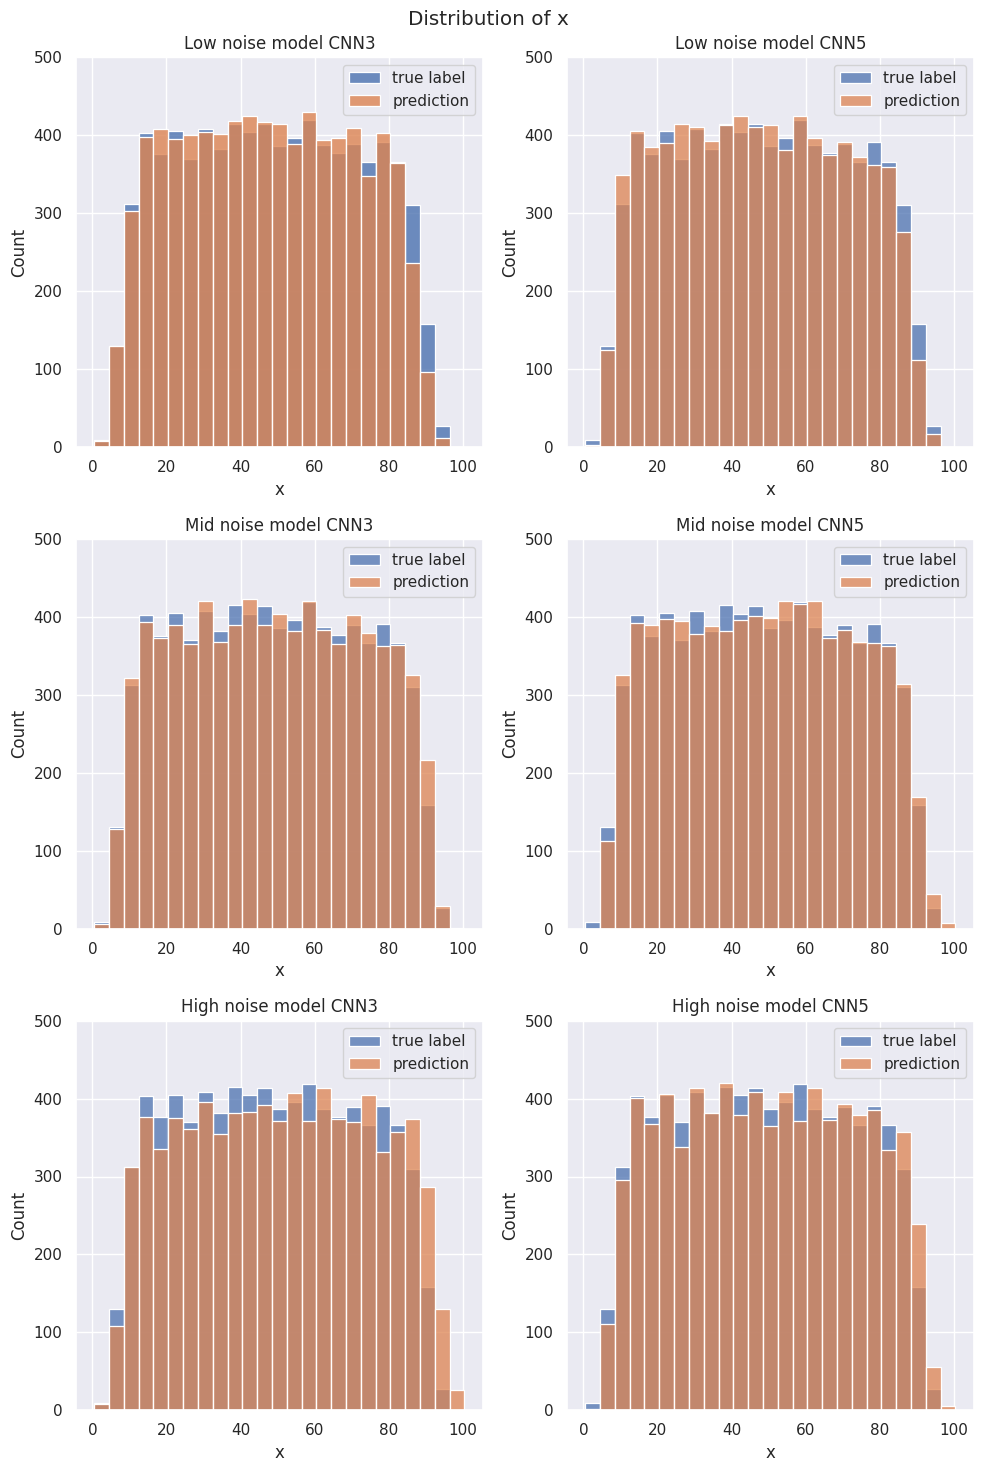

In [34]:

# create figure 
f, axs = plt.subplots(3, 2, figsize=(10, 15))


# noise_levels = np.array([[0.1, 0.3, 0.5],
#                         [0.7, 0.9, 1.1]])
# Read image

bins = np.linspace(0.5,100.5,51)
bins = np.linspace(0.5,100.5,26)
print(bins)

# there is a problem in the data creation, x0, y0 should be uniform
sns.histplot(ax = axs[0,0], data = df_CNN3_low, x = 'x',bins = bins,label = 'true label',alpha = 0.8)
sns.histplot(ax = axs[0,0], data = df_CNN3_low, x = 'x_hat',bins = bins,label = 'prediction',alpha = 0.8)
sns.histplot(ax = axs[0,1], data = df_CNN5_low, x = 'x',bins = bins,label = 'true label')
sns.histplot(ax = axs[0,1], data = df_CNN5_low, x = 'x_hat',bins = bins,label = 'prediction')

sns.histplot(ax = axs[1,0], data = df_CNN3_mid, x = 'x',bins = bins,label = 'true label')
sns.histplot(ax = axs[1,0], data = df_CNN3_mid, x = 'x_hat',bins = bins,label = 'prediction')
sns.histplot(ax = axs[1,1], data = df_CNN5_mid, x = 'x',bins = bins,label = 'true label')
sns.histplot(ax = axs[1,1], data = df_CNN5_mid, x = 'x_hat',bins = bins,label = 'prediction')

sns.histplot(ax = axs[2,0], data = df_CNN3_high, x = 'x',bins = bins,label = 'true label')
sns.histplot(ax = axs[2,0], data = df_CNN3_high, x = 'x_hat',bins = bins,label = 'prediction')
sns.histplot(ax = axs[2,1], data = df_CNN5_high, x = 'x',bins = bins,label = 'true label')
sns.histplot(ax = axs[2,1], data = df_CNN5_high, x = 'x_hat',bins = bins,label = 'prediction')

plt.suptitle('Distribution of x ')
axs[0,0].set_title('Low noise - CNN3')
axs[0,1].set_title('Low noise - CNN5')
axs[1,0].set_title('Mid noise - CNN3')
axs[1,1].set_title('Mid noise - CNN5')
axs[2,0].set_title('High noise - CNN3')
axs[2,1].set_title('High noise - CNN5')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[2,0].legend()
axs[2,1].legend()

axs[0,0].set_ylim([0,500])
axs[0,1].set_ylim([0,500])
axs[1,0].set_ylim([0,500])
axs[1,1].set_ylim([0,500])
axs[2,0].set_ylim([0,500])
axs[2,1].set_ylim([0,500])
plt.tight_layout()


The distribution of the predicted and the true x positions are very similar across the models which shows that the position is very well estimated even for high noise for which the circles are barely visible to the human eye. The histogram also show the minor flaw of how the data set was generated. The bins under 15 and over 85 contain far less observations that fade out to zero on both sides of the spectrum. The initial fear that a underrepresentation of those x positions lead to a worse predicition did not seem to have materialized.



[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5]


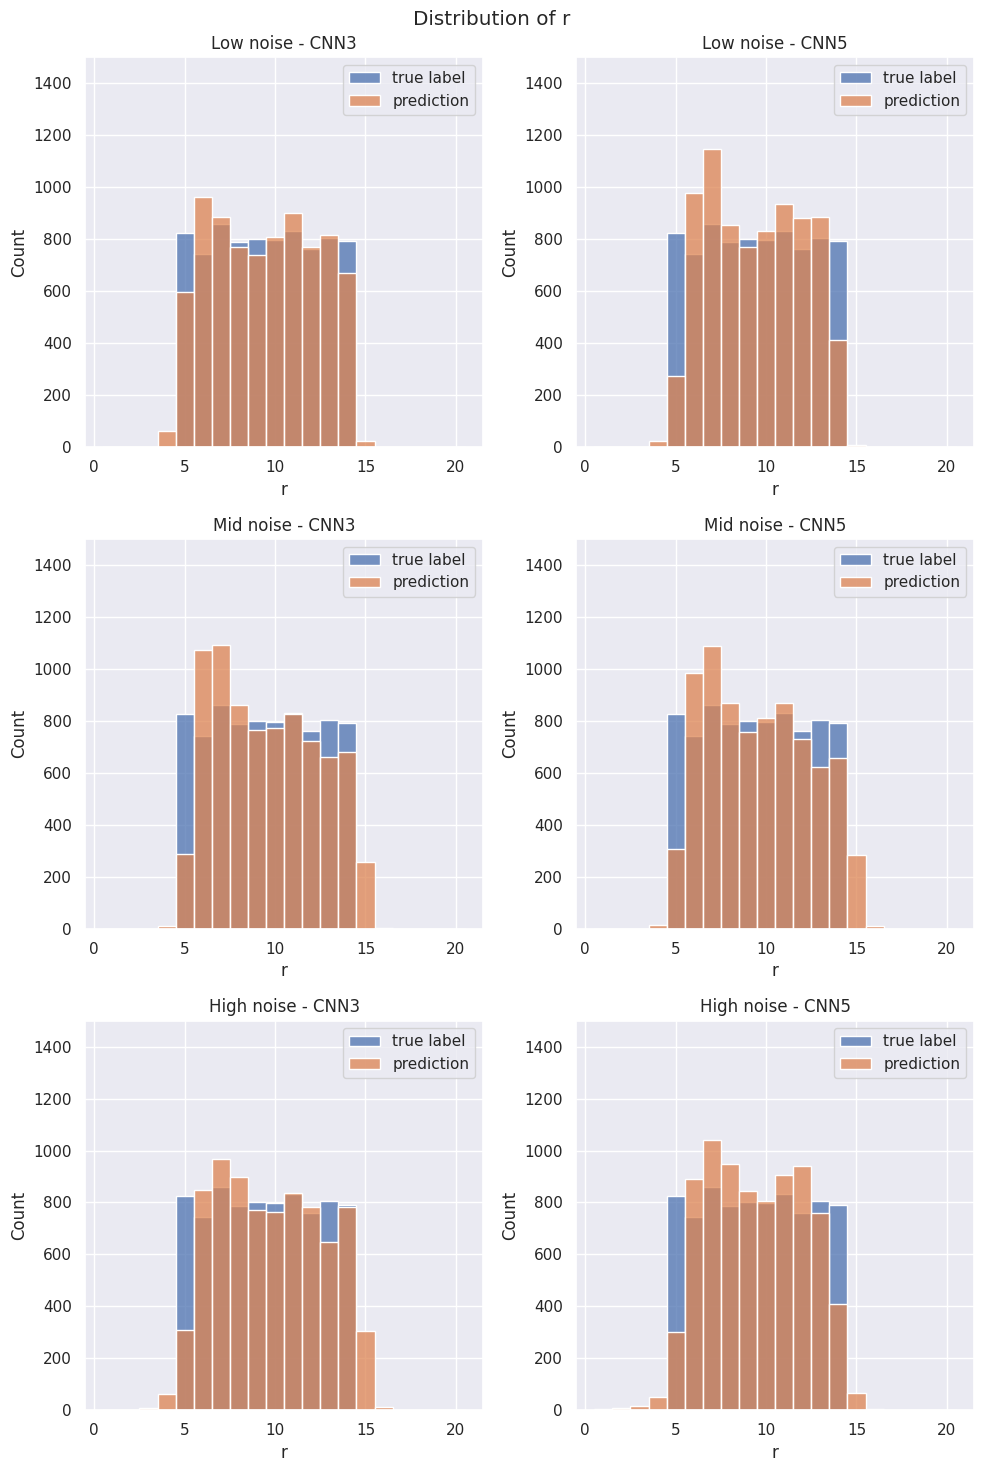

In [37]:

# create figure 
f, axs = plt.subplots(3, 2, figsize=(10, 15))


# noise_levels = np.array([[0.1, 0.3, 0.5],
#                         [0.7, 0.9, 1.1]])
# Read image

bins = np.linspace(0.5,20.5,21)
print(bins)

# there is a problem in the data creation, x0, y0 should be uniform
sns.histplot(ax = axs[0,0], data = df_CNN3_low, x = 'r',bins = bins,label = 'true label')
sns.histplot(ax = axs[0,0], data = df_CNN3_low, x = 'r_hat',bins = bins,label = 'prediction')
sns.histplot(ax = axs[0,1], data = df_CNN5_low, x = 'r',bins = bins,label = 'true label')
sns.histplot(ax = axs[0,1], data = df_CNN5_low, x = 'r_hat',bins = bins,label = 'prediction')

sns.histplot(ax = axs[1,0], data = df_CNN3_mid, x = 'r',bins = bins,label = 'true label')
sns.histplot(ax = axs[1,0], data = df_CNN3_mid, x = 'r_hat',bins = bins,label = 'prediction')
sns.histplot(ax = axs[1,1], data = df_CNN5_mid, x = 'r',bins = bins,label = 'true label')
sns.histplot(ax = axs[1,1], data = df_CNN5_mid, x = 'r_hat',bins = bins,label = 'prediction')

sns.histplot(ax = axs[2,0], data = df_CNN3_high, x = 'r',bins = bins,label = 'true label')
sns.histplot(ax = axs[2,0], data = df_CNN3_high, x = 'r_hat',bins = bins,label = 'prediction')
sns.histplot(ax = axs[2,1], data = df_CNN5_high, x = 'r',bins = bins,label = 'true label')
sns.histplot(ax = axs[2,1], data = df_CNN5_high, x = 'r_hat',bins = bins,label = 'prediction')

plt.suptitle('Distribution of r')
axs[0,0].set_title('Low noise - CNN3')
axs[0,1].set_title('Low noise - CNN5')
axs[1,0].set_title('Mid noise - CNN3')
axs[1,1].set_title('Mid noise - CNN5')
axs[2,0].set_title('High noise - CNN3')
axs[2,1].set_title('High noise - CNN5')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[2,0].legend()
axs[2,1].legend()

axs[0,0].set_ylim([0,1500])
axs[0,1].set_ylim([0,1500])
axs[1,0].set_ylim([0,1500])
axs[1,1].set_ylim([0,1500])
axs[2,0].set_ylim([0,1500])
axs[2,1].set_ylim([0,1500])
plt.tight_layout()

The distribution of the predicted and the true r positions are very similar across the models and different levels of noises. It is quite impressive that there are is a relatively small amount of predicted values outside the range of true labels. For high noise, the models' predictions seem to fade out at both sides of the spectrum. 

### MSE for position and shape

The MSE is analyzed for the test set for the positional variables x,y and the shape variable r independantly to further dive into the models behavior. 


In [29]:
from sklearn.metrics import root_mean_squared_error,mean_squared_error 
import glob
import os

# calculate the MSE for each variable independantly
rmse_df_CNN3 = pd.DataFrame({'x':np.nan,'y':np.nan,'r':np.nan},index=noise_levels)
rmse_df_CNN5 = pd.DataFrame({'x':np.nan,'y':np.nan,'r':np.nan},index=noise_levels)
for noise_lvl in noise_levels:
    idx = pred_CNN3['noise']== noise_lvl
    rmse_df_CNN3.loc[noise_lvl,'x'] = root_mean_squared_error(pred_CNN3.loc[idx]['x'],pred_CNN3.loc[idx]['x_hat'])
    rmse_df_CNN3.loc[noise_lvl,'y'] = root_mean_squared_error(pred_CNN3.loc[idx]['y'],pred_CNN3.loc[idx]['y_hat'])
    rmse_df_CNN3.loc[noise_lvl,'r'] = root_mean_squared_error(pred_CNN3.loc[idx]['r'],pred_CNN3.loc[idx]['r_hat'])

    idx = pred_CNN5['noise']== noise_lvl
    rmse_df_CNN5.loc[noise_lvl,'x'] = root_mean_squared_error(pred_CNN5.loc[idx]['x'],pred_CNN5.loc[idx]['x_hat'])
    rmse_df_CNN5.loc[noise_lvl,'y'] = root_mean_squared_error(pred_CNN5.loc[idx]['y'],pred_CNN5.loc[idx]['y_hat'])
    rmse_df_CNN5.loc[noise_lvl,'r'] = root_mean_squared_error(pred_CNN5.loc[idx]['r'],pred_CNN5.loc[idx]['r_hat'])
    

#mse_df_CNN3 = mse_df_CNN3.rename_axis('noise').reset_index()
print(rmse_df_CNN3)
print(rmse_df_CNN5)


            x         y         r
0.3  1.356143  1.492984  0.447493
0.5  1.121160  1.189170  0.497745
0.7  1.169615  1.287828  0.590021
0.9  1.547861  1.402186  0.666615
1.1  3.040292  3.079164  0.742294
            x         y         r
0.3  1.154610  1.229736  0.680074
0.5  1.677833  1.529420  0.855058
0.7  0.960273  1.061308  0.628291
0.9  1.008774  1.016673  0.643525
1.1  1.709751  1.748750  0.902704


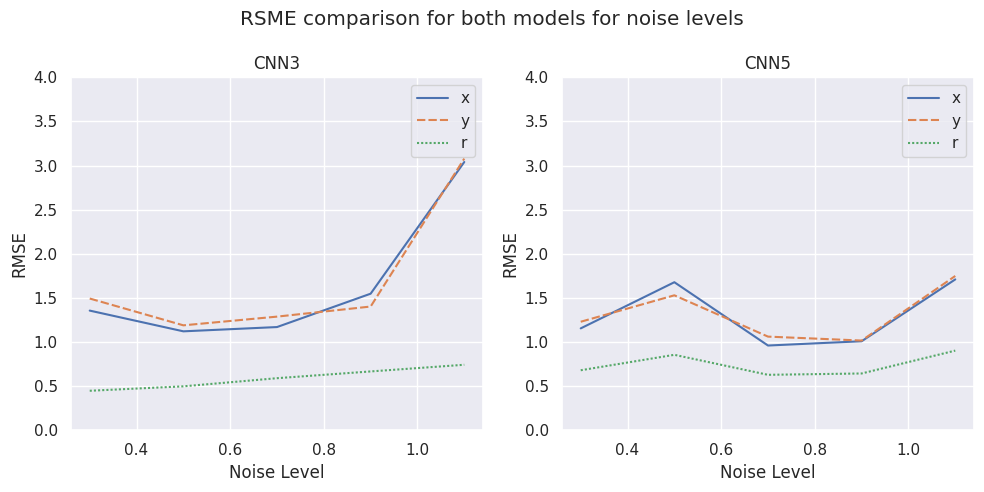

In [30]:
# plotting MSE
f, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(ax=axs[0],data=rmse_df_CNN3[['x', 'y', 'r']])
sns.lineplot(ax=axs[1],data=rmse_df_CNN5[['x', 'y', 'r']])
axs[0].set_xlabel('Noise Level')
axs[1].set_xlabel('Noise Level')
axs[0].set_ylabel('RMSE')
axs[1].set_ylabel('RMSE')
axs[0].set_title('CNN3')
axs[1].set_title('CNN5')
axs[0].set_ylim([0,4])
axs[1].set_ylim([0,4])
plt.suptitle('RSME comparison for both models for noise levels')
plt.tight_layout()
#sns.lineplot(ax= axs[0], data = mse_df_CNN3, x = 'noise',y =['x','y'])

Both models show a very similar level of noise for x and y, which is to be expected.
The less complex model CNN3 shows a linearly increasing RMSE for increasing noise. This trend is not seen in the CNN5 model, yet the overall levels of RMSE are lower for the CNN3 model.
For very high noise of 1.1 (which makes the cirlces barely visible), the CNN3 starts to incur higher errors for x and y. The CNN5 model only makes a average error of estimation x and y under 2 pixels, which is quite impressive.

During training some models reacted very differently than others. CNN3 with a noise level of 0.9 reacted very differently in training and requires a lower learning rate, as it does not converge well. While observing the predictions, the position remained very robust, i.e. the histograms of x for predicition and true label did not change drastically. The fluctuations in the RMSE per epoch only seemed to occur in the optimization of the radius. This shows that parameters might affect the radius estimation more and might require a smaller learning rate than for x and y.

## Summary

Two convolutional networks have been built and compared to solve the task of finding the position and radius of a circle in noisy images. Considering the differing complexity of the model, both models performed similarly well for this regression task. Only for the highest level of noise, the more complex model CNN5 performed slightly better.



## Outlook

### Number of epochs and learning rate
After alot of investigations for the right combination of learning rate and batch size, I started training all models with the same learning rate of 1e-3 and batch size of 100 to keep as many parameters constant between the models.
After finishing all the training (which took some time) I realized that every noise level basically represents a slightly different task for the model to solve. Therefore, the optimal learning rate might also change. For some models, the test error did not converge well even if the number of epochs is drastically increased. These analyses are not included in this report. I investigated the MSE for each variable independantly during training and then continued training. The problem is the radius which has a harder time converging for both models. A very slight decrease in the learning rate might have solved this problem.
I would really like to come back to this project and visit the issue of convergence and whether the different scale of x and y compared to the radius play a role in this. 
Maybe a split model (presented in this [publication](https://www.researchgate.net/publication/355760763_Using_deep_learning_to_predict_the_East_Asian_summer_monsoon
)) for radius and position could stabilze the training. This could treat radius and position independantly, which could open up the potential for a model with less depth (less parameters) and therefore shorter training time.


Feel free to reach out to me or to check out my portfolio. I am happy to discuss my work and gain new insights. 


[Return to Portfolio Page](https://sebastianghafafian.github.io/Portfolio/)
